#### We retrain the model using the support to do the n-shot learning
**Note**: each k and each fold is an independent training
For example, in our experiment, we have 6 smaples in each class for the k-shot learning.

The data partitioning is listed below for 1-, 2-, 3-shot learning.

In total, we have 11 independent trained models. 

Meaning that, in each trained model, the support and test samples are different. The model never sees the test smaples. 






| K Fold | \#Samples in supp. set | \#Samples in test set     | \#Folds  | 
| :---   |    :----:              |        :----:             | :----:   | 
| 1      | 1                      | 5                         | 6/1=6    | 
| 2      | 2                      | 4                         | 6/2=3    |
| 3      | 3                      | 3                         | 6/3=2    |

In [1]:
import xarray as xr
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import keras
import tensorflow as tf
import os
from keras import backend as k
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import pandas as pd
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, Callback
# from keras.models import load_model
# from tensorflow.keras.models import load_model

2024-09-01 22:19:30.426202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-01 22:19:30.439542: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-01 22:19:30.443473: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-01 22:19:30.457022: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-01 22:19:31.097695: W tensorflow/compiler/tf2

In [2]:
# Load the support dataset 
# Here we take 3-shot 1 fold for example
# Change this to a loop to exhaust all the data partitioning 
k = 1
i = 5
support_path = f'/data/Projects/2024_Invasive_species/Tree_Classification/notebooks/data_agu/n_fold_x_validation/{k}_shot_{i}_fold_supp_pairs.zarr'
support_set = xr.open_zarr(support_path)
support_set

images_pair = support_set["X"].to_numpy()/255 # Scale to [0, 1]
labels_pair = support_set["Y"].to_numpy()


In [3]:
@keras.saving.register_keras_serializable(package="MyLayers")
class euclidean_lambda(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(euclidean_lambda, self).__init__(**kwargs)
        self.name = 'euclidean_lambda'

    def call(self, featA, featB):
        squared = keras.ops.square(featA-featB)
        return squared

# model = keras.saving.load_model('../optimized_models/siamese_model.keras')
# model = keras.saving.load_model('/data/Projects/2024_Invasive_species/Tree_Classification/optimized_models/siamese_model.keras')
# model = keras.saving.load_model('/data/Projects/2024_Invasive_species/Tree_Classification/optimized_models/results_training/More_dissimilar_pairs_training_v8/siamese_model.keras')
model = keras.saving.load_model('/data/Projects/2024_Invasive_species/Tree_Classification/optimized_models/results_training/Agu_pairs_training_v8/siamese_model_mobilenet03.keras')
model.summary()

2024-09-01 22:19:32.935860: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 42610 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:21:00.0, compute capability: 8.6


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_93CLO… │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128)       │  3,524,160 │ keras_tensor_93C… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ euclidean_lambda    │ (None, 128)       │          0 │ functional[0][0], │
│ (euclidean_lambda)  │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ euclidean_lambda… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,529,093 (40.17 MB)

 Trainable params: 3,502,401 (13.36 MB)

 Non-trainable params: 21,888 (85.50 KB)

 Optimizer params: 7,004,804 (26.72 MB)

In [4]:
# Setup the refinement training
#Compile model
lr_init = 2.5e-05 # initial learning rate
metrics = [keras.metrics.BinaryAccuracy(threshold=0.5)]    
opt = keras.optimizers.Adam(learning_rate=lr_init)
loss = keras.losses.BinaryCrossentropy(from_logits=False)
model.compile(loss=loss, optimizer=opt, metrics=metrics)

# Configure training  
train_name = f'{k}_shot_{i}_fold/'  
dir_training = Path("/data/Projects/2024_Invasive_species/Tree_Classification/optimized_models/refine_model/") / train_name
dir_training.mkdir(exist_ok=True)

In [5]:
def plot_history(history, metrics):
    """
    Plot the training history

    Args:
        history (keras History object that is returned by model.fit())
        metrics (str, list): Metric or a list of metrics to plot
    """
    history_df = pd.DataFrame.from_dict(history.history)
    fig = plt.figure(figsize=(10, 5))
    sns.lineplot(data=history_df[metrics])
    plt.xlabel("epochs")
    plt.ylabel("metric")
    plt.ylim(0, 1)

In [6]:
def plot_prediction(labels_pred, labels_pair):
    fig = plt.figure(figsize=(10, 5))
    
    sub = fig.add_subplot(1, 2, 1)
    sub.plot(labels_pred[labels_pair==1], '.', markersize=0.5)
    sub.plot(labels_pair[labels_pair==1])

    sub = fig.add_subplot(1, 2, 2)
    sub.plot(labels_pred[labels_pair==0], '.', markersize=0.5)
    sub.plot(labels_pair[labels_pair==0],)

In [7]:
def plot_prediction_hist(labels_pred):
    fig = plt.figure(figsize=(10, 5))

    counts, bins = np.histogram(labels_pred[labels_pair==1])
    sub = fig.add_subplot(1, 2, 1)
    sub.stairs(counts, bins)

    sub = fig.add_subplot(1, 2, 2)
    counts, bins = np.histogram(labels_pred[labels_pair==0])
    sub.stairs(counts, bins)

In [8]:
# Custom callback to plot predictions every 10 epochs
class PlotPredictionsCallback(Callback):
    def __init__(self, x_val, y_val, dir_training):
        super(PlotPredictionsCallback, self).__init__()
        self.x_val = x_val
        self.y_val = y_val
        self.dir_training = dir_training
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 2 == 0:
            
            # Make predictions on the validation data
            images_pair = self.x_val
            labels_pred = self.model.predict([images_pair[:,0], images_pair[:,1]])
            
            dir_epoch = self.dir_training / f'epoch_{epoch+1}'
            dir_epoch.mkdir(exist_ok=True)
            
            # Plots
            plot_prediction(labels_pred, self.y_val)
            plt.savefig(dir_epoch/'prediction.png')
            plot_prediction_hist(labels_pred)
            plt.savefig(dir_epoch/'prediction_hist.png')
            plt.close('all')

In [9]:
# Set callbacks
# learning_rate_scheduler = LearningRateScheduler(lr_schedule)
learning_rate_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
plot_pred_callback = PlotPredictionsCallback(images_pair, labels_pair, dir_training)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=5, restore_best_weights=True)
callbacks = [learning_rate_scheduler, plot_pred_callback, earlystop]

history = model.fit([images_pair[:,0], images_pair[:,1]], labels_pair[:], batch_size=4, epochs=10, validation_split=0.2, callbacks=callbacks)


Epoch 1/10


I0000 00:00:1725221983.157067 3593921 service.cc:146] XLA service 0x7f5810004fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725221983.157117 3593921 service.cc:154]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-09-01 22:19:43.446586: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-01 22:19:44.771247: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


 18/118 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.8270 - loss: 1.0858

I0000 00:00:1725221998.208630 3593921 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/stepep - binary_accuracy: 0.7997 - loss
118/118 ━━━━━━━━━━━━━━━━━━━━ 47s 200ms/step - binary_accuracy: 0.7998 - loss: 1.1544 - val_binary_accuracy: 0.8136 - val_loss: 0.6072 - learning_rate: 2.5000e-05
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - binary_accuracy: 0.9448 - loss: 0.2859 - val_binary_accuracy: 0.7288 - val_loss: 0.9758 - learning_rate: 2.5000e-05
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step p - binary_accuracy: 0.9351 - loss: 0.2
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - binary_accuracy: 0.9350 - loss: 0.2594 - val_binary_accuracy: 0.6610 - val_loss: 0.8943 - learning_rate: 2.5000e-05
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.9191 - loss: 0.2554 - val_binary_accuracy: 0.7373 - val_loss: 0.6805 - learning_rate: 2.5000e-05
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step p - binary_accuracy: 0.9568 - loss: 0.1
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - binary_accuracy: 0.9570 - loss: 0.135

In [10]:
# Save model
keras.saving.save_model(model, dir_training / 'siamese_model_refined.keras', overwrite=True)
model.save_weights(dir_training / "optimized_weights_refined.weights.h5")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


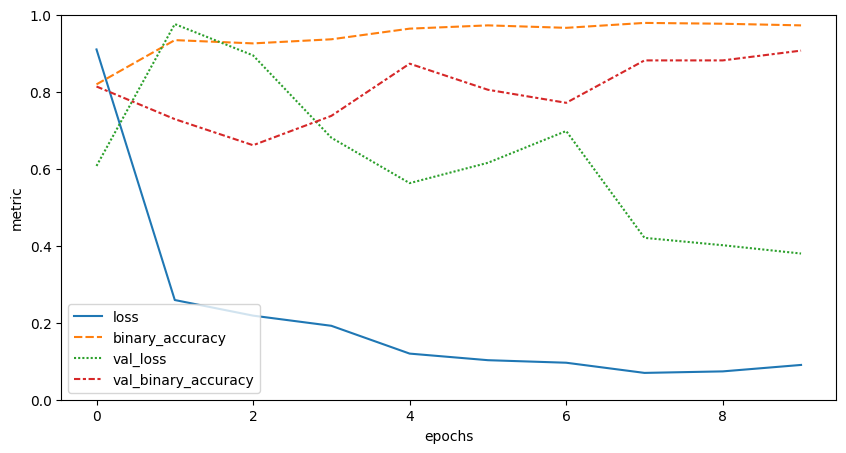

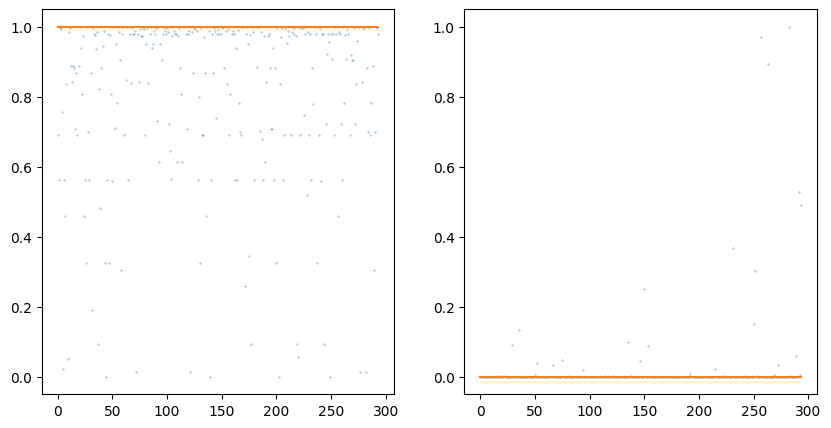

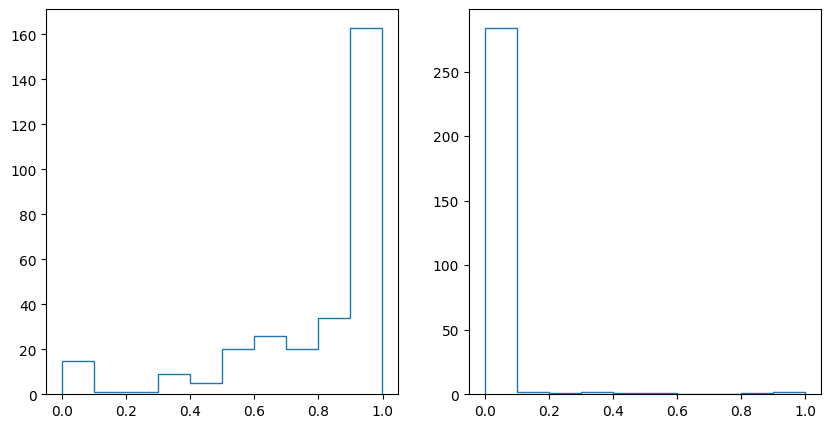

In [11]:
with open(dir_training / "history.pkl", "wb") as file_pi:
        pickle.dump(history, file_pi)
    
# Model evaluation plots
model_loaded = keras.saving.load_model(dir_training / 'siamese_model_refined.keras', compile=False)
labels_pred = model.predict([images_pair[:, 0], images_pair[:, 1]])
plot_history(history, ['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
plt.savefig(dir_training / "history.png")
plot_prediction(labels_pred, labels_pair)
plt.savefig(dir_training / "prediction.png")
plot_prediction_hist(labels_pred)
plt.savefig(dir_training / "prediction_hist.png")